In [30]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/used-car-price-prediction-dataset/used_cars.csv


### Importing Libraries

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import KNNImputer

In [32]:
warnings.filterwarnings('ignore')

In [33]:
sns.set(style="whitegrid")

In [76]:
# Load used car data
df=pd.read_csv('used_cars.csv')
df.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,Ford,Utility Police Interceptor Base,2013,"51,000 mi.",E85 Flex Fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,6-Speed A/T,Black,Black,At least 1 accident or damage reported,Yes,"$10,300"
1,Hyundai,Palisade SEL,2021,"34,742 mi.",Gasoline,3.8L V6 24V GDI DOHC,8-Speed Automatic,Moonlight Cloud,Gray,At least 1 accident or damage reported,Yes,"$38,005"
2,Lexus,RX 350 RX 350,2022,"22,372 mi.",Gasoline,3.5 Liter DOHC,Automatic,Blue,Black,None reported,NaN,"$54,598"
3,INFINITI,Q50 Hybrid Sport,2015,"88,900 mi.",Hybrid,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,7-Speed A/T,Black,Black,None reported,Yes,"$15,500"
4,Audi,Q3 45 S line Premium Plus,2021,"9,835 mi.",Gasoline,2.0L I4 16V GDI DOHC Turbo,8-Speed Automatic,Glacier White Metallic,Black,None reported,NaN,"$34,999"


### basic analysis about dataset

In [77]:
df.shape

(4009, 12)

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4009 entries, 0 to 4008
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   brand         4009 non-null   object
 1   model         4009 non-null   object
 2   model_year    4009 non-null   int64 
 3   milage        4009 non-null   object
 4   fuel_type     3839 non-null   object
 5   engine        4009 non-null   object
 6   transmission  4009 non-null   object
 7   ext_col       4009 non-null   object
 8   int_col       4009 non-null   object
 9   accident      3896 non-null   object
 10  clean_title   3413 non-null   object
 11  price         4009 non-null   object
dtypes: int64(1), object(11)
memory usage: 376.0+ KB


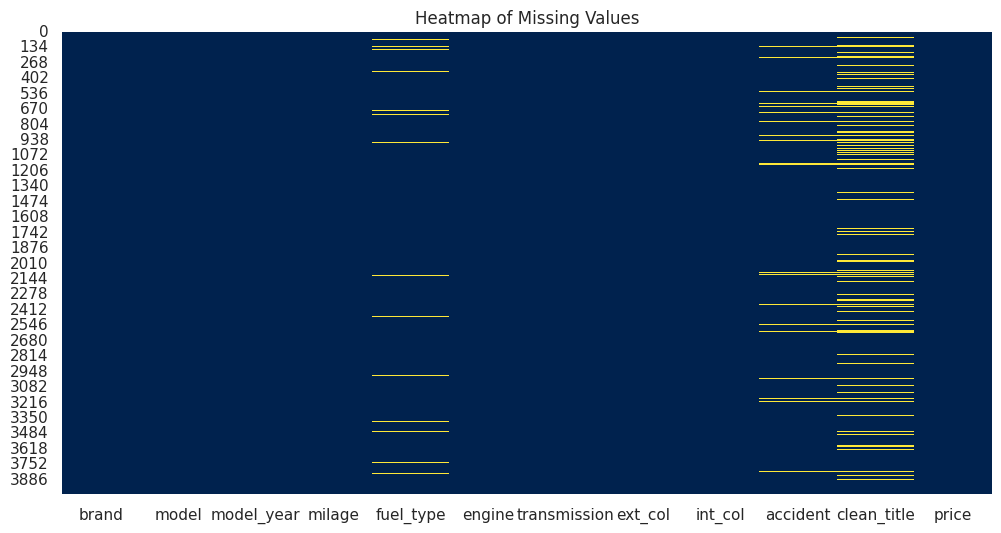

brand             0
model             0
model_year        0
milage            0
fuel_type       170
engine            0
transmission      0
ext_col           0
int_col           0
accident        113
clean_title     596
price             0
dtype: int64


In [79]:
# representing Null values in dataset by grapical and numerical representation 
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='cividis')
plt.title('Heatmap of Missing Values')
plt.show()
print(df.isnull().sum())

In [80]:
# Remove 'mi.'
df['milage'] = df['milage'].str.replace('mi.', '', regex=False).str.replace(',', '')

# Convert to numeric
df['milage'] = pd.to_numeric(df['milage'])

# Remove '$'
df['price'] = df['price'].str.replace('$', '', regex=False).str.replace(',', '')

# Convert to numeric
df['price'] = pd.to_numeric(df['price'])

In [81]:
for col in df:
    if df[col].dtype == 'O':
        print(f"Unique value in '{col}':")
        print(pd.unique(df[col]))
        print(f"Count of unique values in '{col}': {len(pd.unique(df[col]))}")
        print()
        print()

Unique value in 'brand':
['Ford' 'Hyundai' 'Lexus' 'INFINITI' 'Audi' 'Acura' 'BMW' 'Tesla' 'Land'
 'Aston' 'Toyota' 'Lincoln' 'Jaguar' 'Mercedes-Benz' 'Dodge' 'Nissan'
 'Genesis' 'Chevrolet' 'Kia' 'Jeep' 'Bentley' 'Honda' 'Lucid' 'MINI'
 'Porsche' 'Hummer' 'Chrysler' 'Volvo' 'Cadillac' 'Lamborghini' 'Maserati'
 'Volkswagen' 'Subaru' 'Rivian' 'GMC' 'RAM' 'Alfa' 'Ferrari' 'Scion'
 'Mitsubishi' 'Mazda' 'Saturn' 'Bugatti' 'Polestar' 'Rolls-Royce'
 'McLaren' 'Buick' 'Lotus' 'Pontiac' 'FIAT' 'Karma' 'Saab' 'Mercury'
 'Plymouth' 'smart' 'Maybach' 'Suzuki']
Count of unique values in 'brand': 57


Unique value in 'model':
['Utility Police Interceptor Base' 'Palisade SEL' 'RX 350 RX 350' ...
 'Martin DB7 Vantage Volante' 'Impala 2LZ' 'Taycan']
Count of unique values in 'model': 1898


Unique value in 'fuel_type':
['E85 Flex Fuel' 'Gasoline' 'Hybrid' nan 'Diesel' 'Plug-In Hybrid' '–'
 'not supported']
Count of unique values in 'fuel_type': 8


Unique value in 'engine':
['300.0HP 3.7L V6 Cylinder 

In [82]:
unique_values = df['engine'].unique()
unique_values[:50]  # Preview the first 10 unique values

array(['300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capability',
       '3.8L V6 24V GDI DOHC', '3.5 Liter DOHC',
       '354.0HP 3.5L V6 Cylinder Engine Gas/Electric Hybrid',
       '2.0L I4 16V GDI DOHC Turbo', '2.4 Liter',
       '292.0HP 2.0L 4 Cylinder Engine Gasoline Fuel',
       '282.0HP 4.4L 8 Cylinder Engine Gasoline Fuel',
       '311.0HP 3.5L V6 Cylinder Engine Gasoline Fuel',
       '534.0HP Electric Motor Electric Fuel System', 'V6',
       '715.0HP 5.2L 12 Cylinder Engine Gasoline Fuel',
       '382.0HP 3.0L Straight 6 Cylinder Engine Gasoline Fuel',
       '400.0HP 3.0L V6 Cylinder Engine Gasoline Fuel',
       '2.0 Liter Supercharged',
       '375.0HP 5.0L 8 Cylinder Engine Gasoline Fuel',
       '305.0HP 3.6L V6 Cylinder Engine Gasoline Fuel',
       '287.0HP 3.5L V6 Cylinder Engine Gasoline Fuel',
       '550.0HP 5.0L 8 Cylinder Engine Gasoline Fuel',
       '375.0HP 3.5L V6 Cylinder Engine Gasoline Fuel',
       '120.0HP 2.2L 4 Cylinder Engine Flex Fuel Capability',
 

### filling null values

In [83]:
df['clean_title'].fillna('No', inplace=True)
df['accident'].fillna('None reported', inplace=True)
df['fuel_type'].replace(['–', 'not supported'], np.nan, inplace=True)

In [84]:
# Convert the categorical values to numeric for KNNImputer
df['fuel_type'] = df['fuel_type'].replace({
    'E85 Flex Fuel': 1,
    'Gasoline': 2,
    'Hybrid': 3,
    'Diesel': 4,
    'Plug-In Hybrid': 5,
    np.nan: np.nan
})

# Apply KNNImputer
imputer = KNNImputer(n_neighbors=3)
df[['fuel_type']] = imputer.fit_transform(df[['fuel_type']])

# Convert back to categorical after imputation
df['fuel_type'] = df['fuel_type'].round().replace({
    1: 'E85 Flex Fuel',
    2: 'Gasoline',
    3: 'Hybrid',
    4: 'Diesel',
    5: 'Plug-In Hybrid'
})

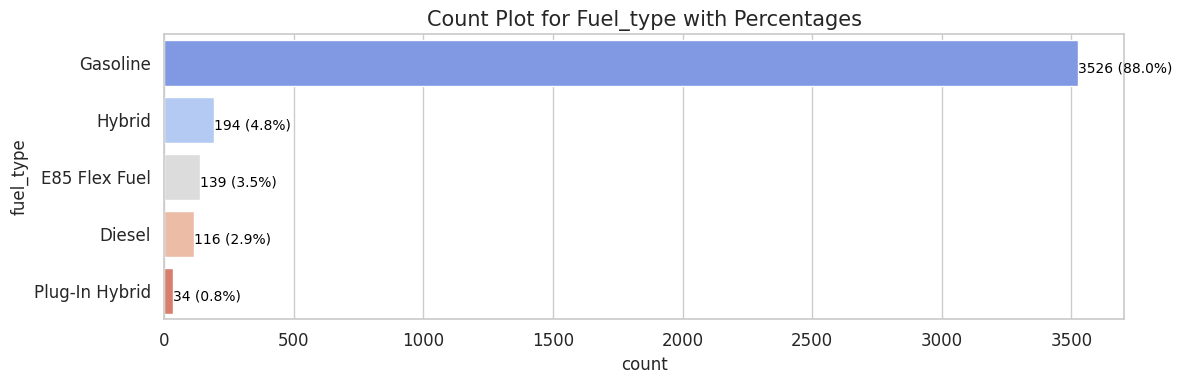

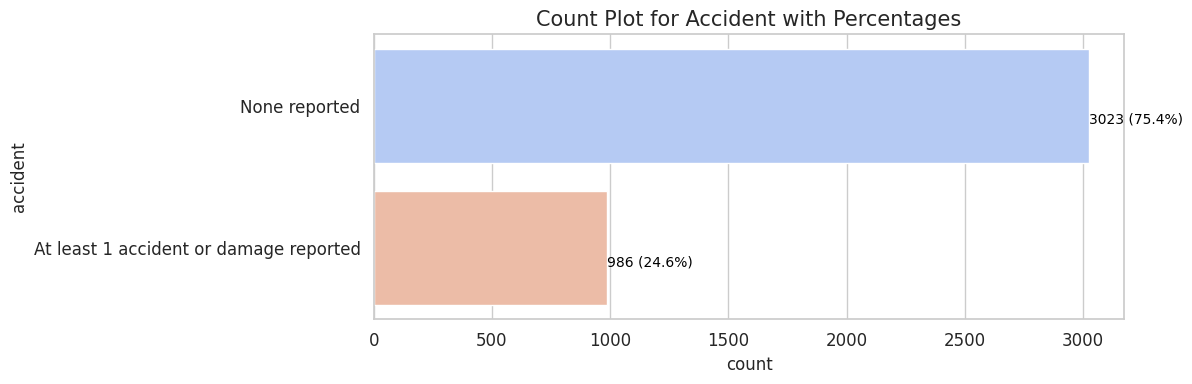

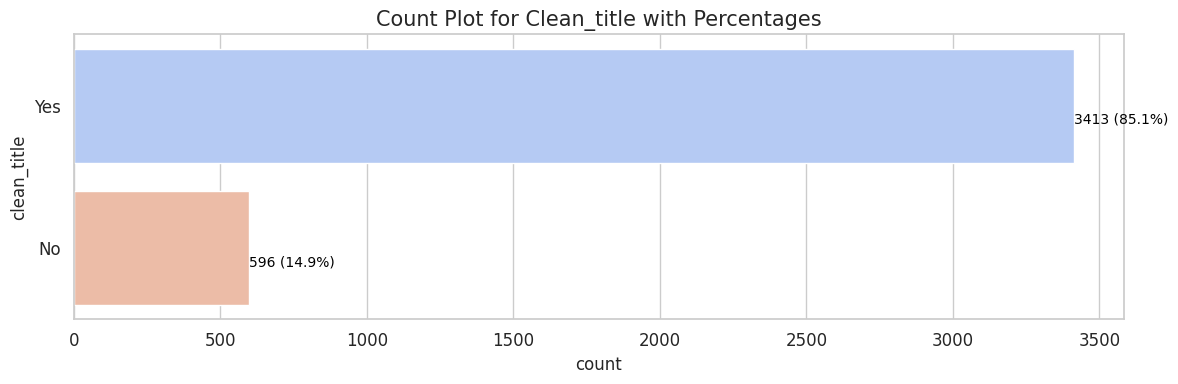

In [85]:
for col in ['fuel_type', 'accident', 'clean_title']:
    plt.figure(figsize=(12, 4))  # Set consistent size
    df[col] = df[col].astype('category')  # Convert to categorical type
    
    # Create the countplot with custom color palette
    ax = sns.countplot(y=col, data=df, palette="coolwarm", order=df[col].value_counts().index)
    
    # Add annotations to each bar
    total = len(df[col])
    for p in ax.patches:
        percentage = f'{100 * p.get_width() / total:.1f}%'  # Calculate percentage
        ax.annotate(f'{int(p.get_width())} ({percentage})', (p.get_width(), p.get_y() + 0.5), 
                    ha='left', va='center', fontsize=10, color='black')

    # Rotate Y labels if needed and add title
    plt.yticks(rotation=0, fontsize=12)
    plt.xticks(fontsize=12)
    plt.title(f'Count Plot for {col.capitalize()} with Percentages', fontsize=15)
    
    plt.tight_layout()
    plt.show()

In [86]:
# function for Extracting relevent informantion from the following column
def extract_fuel_type(engine_info):
    if pd.isna(engine_info):
        return np.nan
    if 'Gasoline' in engine_info:
        return 'Gasoline'
    elif 'Hybrid' in engine_info:
        return 'Hybrid'
    elif 'Flex Fuel' in engine_info or 'E85' in engine_info:
        return 'Flex Fuel'
    elif 'Diesel' in engine_info:
        return 'Diesel'
    elif 'Electric' in engine_info:
        return 'Electric'
    else:
        return 'None'


def extract_transmission_type(transmission):
        if 'Automatic' in transmission:
            return 'Automatic'
        elif 'Manual' in transmission:
            return 'Manual'
        elif 'CVT' in transmission:
            return 'CVT'
        elif 'DCT' in transmission:
            return 'DCT'
        elif 'Fixed Gear' in transmission:
            return 'Fixed Gear'
        elif 'Variable' in transmission:
            return 'Variable'
        elif 'Single-Speed' in transmission:
            return 'Single-Speed'
        else:
            return 'None'  

def categorize_color(color):
    color = color.lower()
    if any(x in color for x in ['black', 'obsidian', 'raven', 'onyx']):
        return 'Black'
    elif any(x in color for x in ['white', 'pearl', 'ivory', 'frost']):
        return 'White'
    elif any(x in color for x in ['blue', 'navy', 'aqua', 'teal']):
        return 'Blue'
    elif any(x in color for x in ['red', 'ruby', 'garnet']):
        return 'Red'
    elif any(x in color for x in ['silver', 'gray', 'grey', 'steel']):
        return 'Silver_Gray'
    elif any(x in color for x in ['green']):
        return 'Green'
    elif any(x in color for x in ['yellow', 'gold', 'orange']):
        return 'Yellow_Orange'
    else:
        return 'Other'

In [87]:
import re
def extract_hp(engine_string):
    # Use regular expression to find patterns like "300.0HP"
    match = re.search(r'(\d+\.?\d*)HP', engine_string)
    if match:
        return float(match.group(1))  # Convert to float for easier manipulation later
    return None  # Return None if no HP value is found

# Apply the function to the engine column
df['horsepower'] = df['engine'].apply(extract_hp)

In [88]:
def extract_cylinders(engine_string):
    # Use regular expression to find patterns like "6 Cylinder" or "4 Cylinder"
    match = re.search(r'(\d+)\s*Cylinder', engine_string)
    if match:
        return int(match.group(1))  # Convert to integer since it's a whole number
    return None  # Return None if no Cylinder value is found

# Apply the function to the engine column
df['Cylinders'] = df['engine'].apply(extract_cylinders)

In [89]:
df['engine'] = df['engine'].apply(extract_fuel_type)
df['transmission_type'] = df['transmission'].apply(extract_transmission_type)
df['categorized_col_ext'] = df['ext_col'].apply(categorize_color)
df['categorized_col_int']=df['int_col'].apply(categorize_color)

In [90]:
# Create a new column 'age' by subtracting the model year from max_year
max_year = df['model_year'].max()
df['age'] = max_year - df['model_year']
df['age']

0       11
1        3
2        2
3        9
4        3
        ..
4004     1
4005     2
4006     2
4007     4
4008     4
Name: age, Length: 4009, dtype: int64

In [91]:
df = df.drop('transmission', axis=1)
df = df.drop('model', axis=1)
df = df.drop('ext_col', axis=1)
df = df.drop('int_col', axis=1)
df = df.drop('model_year', axis=1)

In [92]:
# to find unique values form column having object datatype
for col in df:
    if df[col].dtype == 'O':
        print(f"Unique value in '{col}':")
        print(pd.unique(df[col]))
        print(f"Count of unique values in '{col}': {len(pd.unique(df[col]))}")
        print()
        print()  

Unique value in 'brand':
['Ford' 'Hyundai' 'Lexus' 'INFINITI' 'Audi' 'Acura' 'BMW' 'Tesla' 'Land'
 'Aston' 'Toyota' 'Lincoln' 'Jaguar' 'Mercedes-Benz' 'Dodge' 'Nissan'
 'Genesis' 'Chevrolet' 'Kia' 'Jeep' 'Bentley' 'Honda' 'Lucid' 'MINI'
 'Porsche' 'Hummer' 'Chrysler' 'Volvo' 'Cadillac' 'Lamborghini' 'Maserati'
 'Volkswagen' 'Subaru' 'Rivian' 'GMC' 'RAM' 'Alfa' 'Ferrari' 'Scion'
 'Mitsubishi' 'Mazda' 'Saturn' 'Bugatti' 'Polestar' 'Rolls-Royce'
 'McLaren' 'Buick' 'Lotus' 'Pontiac' 'FIAT' 'Karma' 'Saab' 'Mercury'
 'Plymouth' 'smart' 'Maybach' 'Suzuki']
Count of unique values in 'brand': 57


Unique value in 'engine':
['Flex Fuel' 'None' 'Hybrid' 'Gasoline' 'Electric' 'Diesel']
Count of unique values in 'engine': 6


Unique value in 'transmission_type':
['None' 'Automatic' 'CVT' 'Manual' 'Variable' 'Fixed Gear']
Count of unique values in 'transmission_type': 6


Unique value in 'categorized_col_ext':
['Black' 'Other' 'Blue' 'White' 'Silver_Gray' 'Green' 'Yellow_Orange'
 'Red']
Count of uni

In [93]:
categories = {
    'fuel_type': ['E85 Flex Fuel', 'Gasoline', 'Hybrid', 'Diesel', 'Plug-In Hybrid'],
    'accident': ['None reported', 'At least 1 accident or damage reported'],
    'clean_title': ['No', 'Yes']
}

# Apply Ordinal Encoding
for column, cat_list in categories.items():
    encoder = OrdinalEncoder(categories=[cat_list])
    df[column] = encoder.fit_transform(df[[column]]).astype(int)

### to convert catagorical data to numerical data

In [94]:
# Columns to One-Hot Encode
columns_to_encode = ['brand', 'engine', 'transmission_type', 'categorized_col_ext', 'categorized_col_int']
ohe = OneHotEncoder(drop='first', sparse_output=False)

encoded_columns = ohe.fit_transform(df[columns_to_encode])

encoded_df = pd.DataFrame(encoded_columns, columns=ohe.get_feature_names_out(columns_to_encode))

df = pd.concat([df.reset_index(drop=True), encoded_df], axis=1).drop(columns=columns_to_encode)


In [95]:
df

,milage,fuel_type,accident,clean_title,price,horsepower,Cylinders,age,brand_Alfa,brand_Aston,...,categorized_col_ext_Silver_Gray,categorized_col_ext_White,categorized_col_ext_Yellow_Orange,categorized_col_int_Blue,categorized_col_int_Green,categorized_col_int_Other,categorized_col_int_Red,categorized_col_int_Silver_Gray,categorized_col_int_White,categorized_col_int_Yellow_Orange
0,51000,0,1,1,10300,300.0,6.0,11,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,34742,1,1,1,38005,NaN,NaN,3,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,22372,1,0,0,54598,NaN,NaN,2,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,88900,2,0,1,15500,354.0,6.0,9,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,9835,1,0,0,34999,NaN,NaN,3,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4004,714,1,0,1,349950,NaN,NaN,1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4005,10900,1,0,1,53900,349.0,6.0,2,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4006,2116,1,0,0,90998,NaN,NaN,2,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4007,33000,1,0,1,62999,450.0,6.0,4,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [96]:
df['price'].fillna(df['price'].mean(), inplace=True)
df['Cylinders'].fillna(df['Cylinders'].mean(),inplace=True)
df['horsepower'].fillna(df['horsepower'].mean(), inplace=True)

In [97]:
df.isnull().sum()

milage                               0
fuel_type                            0
accident                             0
clean_title                          0
price                                0
                                    ..
categorized_col_int_Other            0
categorized_col_int_Red              0
categorized_col_int_Silver_Gray      0
categorized_col_int_White            0
categorized_col_int_Yellow_Orange    0
Length: 88, dtype: int64

<Axes: >

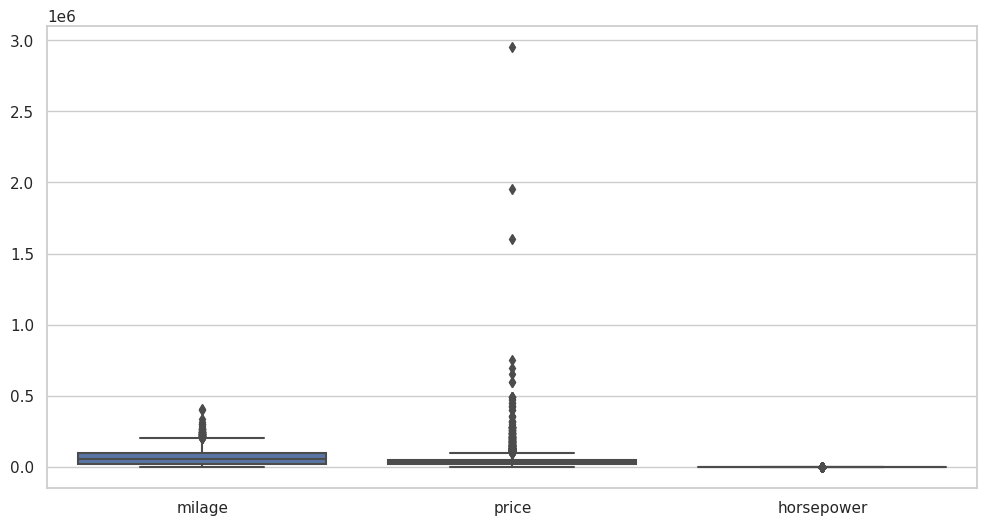

In [98]:
# boxplot shows the distribution, median, and outliers
plt.figure(figsize=(12,6))
sns.boxplot(data=df[['milage','price','horsepower']])

<Axes: >

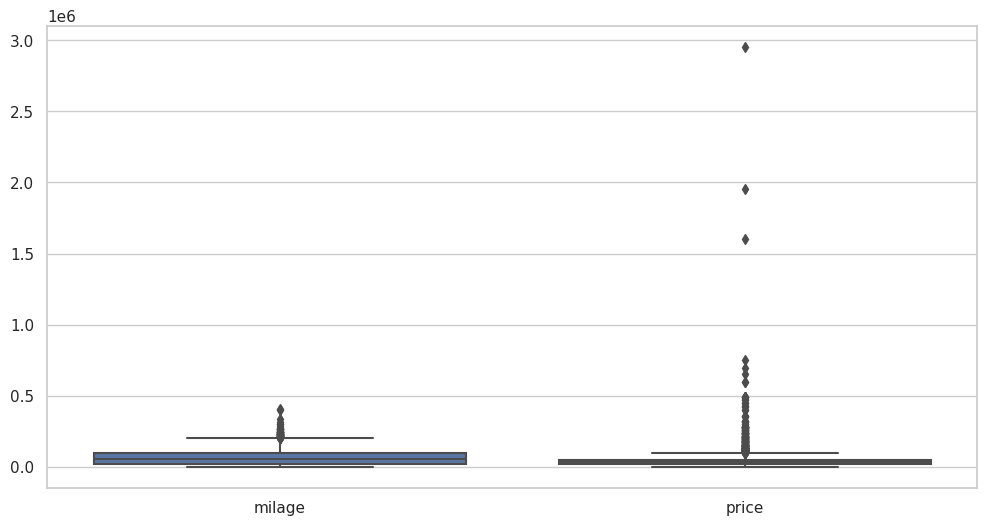

In [99]:
# boxplot shows the distribution, median, and outliers
plt.figure(figsize=(12,6))
sns.boxplot(data=df[['milage','price']])

In [100]:
# converting the price values into log scaleze
df['price'] = np.log1p(df['price'])


In [101]:
df.shape

(4009, 88)

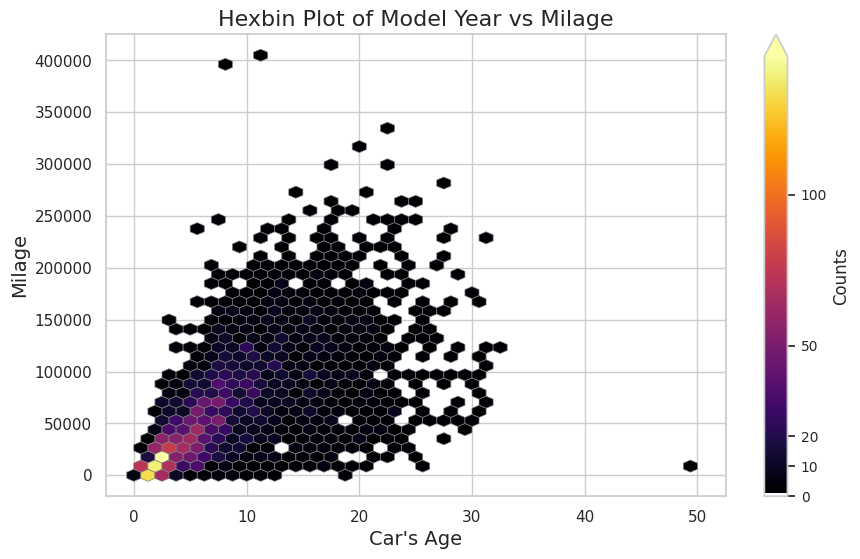

In [102]:
# Create a hexbin plot with a vibrant color map and advanced options
plt.figure(figsize=(10, 6))
plt.hexbin(df['age'], df['milage'], gridsize=40, cmap='inferno', mincnt=1, edgecolors='grey', linewidths=0.5)

# Add labels with increased font size for better visibility
plt.xlabel("Car's Age", fontsize=14)
plt.ylabel('Milage', fontsize=14)
plt.title('Hexbin Plot of Model Year vs Milage', fontsize=16)

# Add a color bar with label
colorbar = plt.colorbar(label='Counts', extend='max')

# Customize the color bar for better contrast
colorbar.set_ticks([0, 10, 20, 50, 100])
colorbar.ax.tick_params(labelsize=10)

# Display the plot
plt.show()

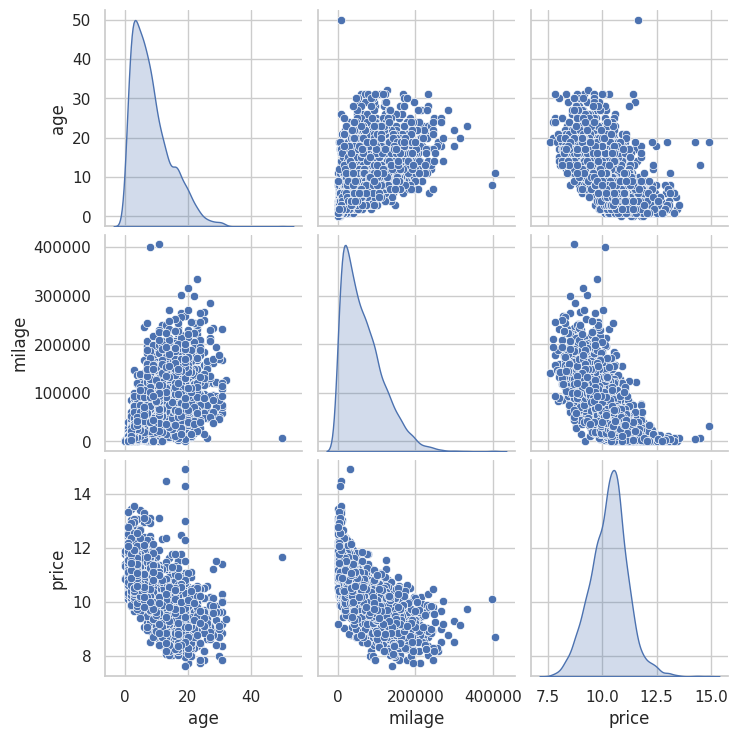

In [103]:
sns.pairplot(df[['age', 'milage', 'price']], diag_kind='kde', palette='coolwarm')
plt.show()

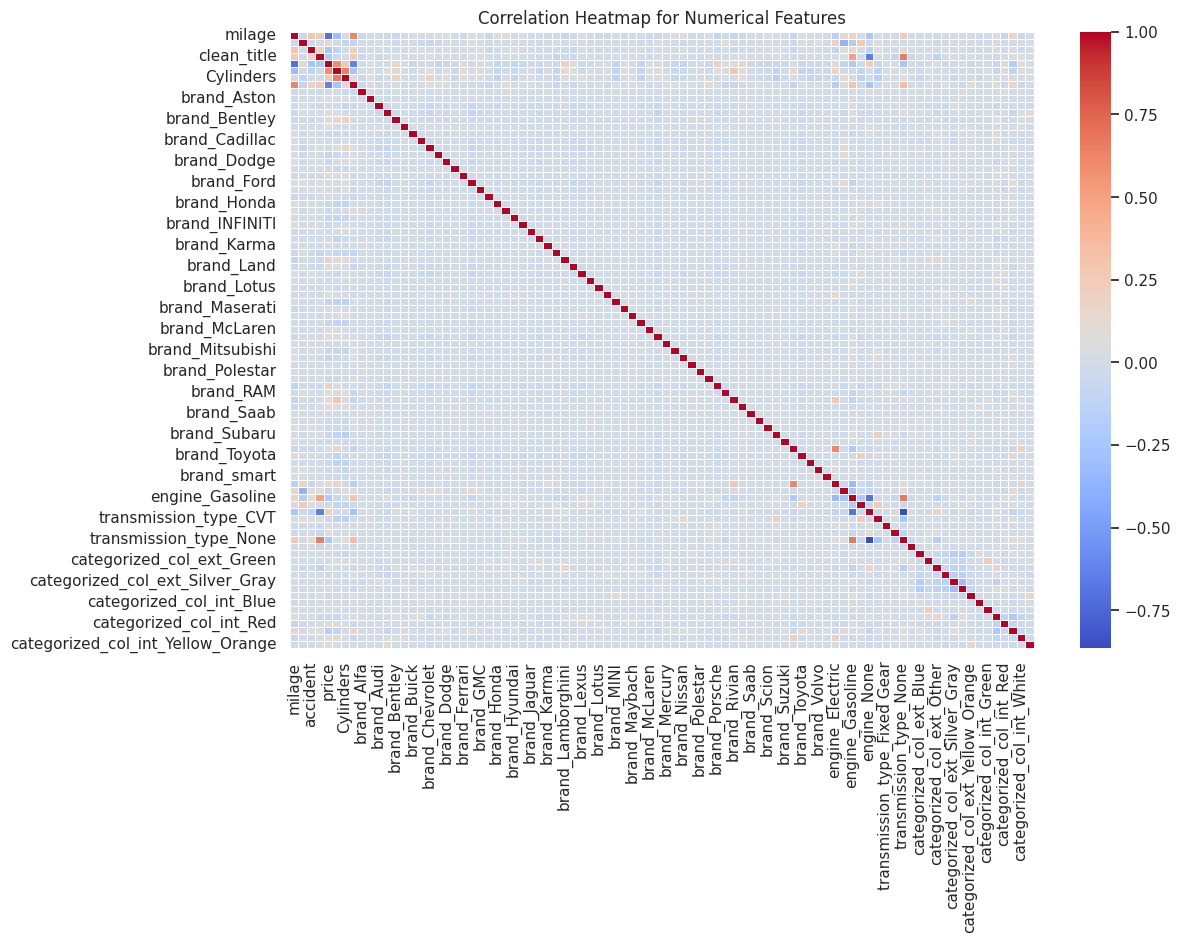

In [104]:
# Correlation heatmap for numerical features
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
corr_matrix = df[numeric_cols].corr()

# Plotting the heatmap without annotations (numbers)
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap for Numerical Features')
plt.show()

In [105]:
### model training and testing

In [106]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [107]:
df

,milage,fuel_type,accident,clean_title,price,horsepower,Cylinders,age,brand_Alfa,brand_Aston,...,categorized_col_ext_Silver_Gray,categorized_col_ext_White,categorized_col_ext_Yellow_Orange,categorized_col_int_Blue,categorized_col_int_Green,categorized_col_int_Other,categorized_col_int_Red,categorized_col_int_Silver_Gray,categorized_col_int_White,categorized_col_int_Yellow_Orange
0,51000,0,1,1,9.239996,300.000000,6.000000,11,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,34742,1,1,1,10.545499,332.206498,6.258159,3,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,22372,1,0,0,10.907771,332.206498,6.258159,2,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,88900,2,0,1,9.648660,354.000000,6.000000,9,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,9835,1,0,0,10.463103,332.206498,6.258159,3,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4004,714,1,0,1,12.765548,332.206498,6.258159,1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4005,10900,1,0,1,10.894904,349.000000,6.000000,2,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4006,2116,1,0,0,11.418604,332.206498,6.258159,2,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4007,33000,1,0,1,11.050890,450.000000,6.000000,4,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [108]:
scaler = StandardScaler()
numeric_cols = ['milage','age','price','horsepower']
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])


# scaler = StandardScaler()
# numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
# df[numeric_cols] = scaler.fit_transform(df[numeric_cols])


In [109]:
X = df.drop('price', axis=1)
y = df['price']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=5)

In [110]:
X.shape

(4009, 87)

In [111]:
y.shape

(4009,)

In [112]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

Random Forest RMSE: 0.3871033651116022
Random Forest R² Score: 0.8415067874688125


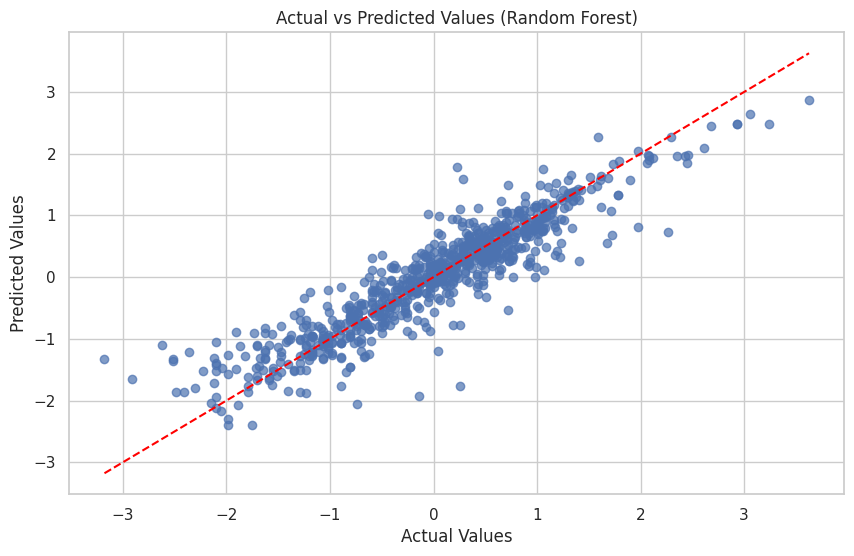

In [113]:
# Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=4)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)

# Calculate RMSE and R² Score
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print(f'Random Forest RMSE: {rmse_rf}')
print(f'Random Forest R² Score: {r2_rf}')

# Compare actual vs predicted values for Random Forest
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.7)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values (Random Forest)')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Diagonal line
plt.show()